In [1]:
import numpy as np
from matplotlib import rc
import matplotlib.pyplot as plt
import os,sys
#from IPython.core.display import display, Latex, Math
# display(HTML("<style>.container { width:100% !important; }</style>"))
import ROOT

Welcome to JupyROOT 6.18/00


In [2]:
#Stuff I will use for all the Histograms
#########################################
sample_name="#scale[0.6]{MicroBooNE In-Progress}";
pot_char="#scale[0.6]{Runs 1+2+3 Accumulated POT: 6.79e+20}"
pot_num = 6.79E+20
t = ROOT.TLatex()
ROOT.gStyle.SetPaintTextFormat("4.2f")
ROOT.gStyle.SetHistMinimumZero(ROOT.kTRUE)
ROOT.gStyle.SetOptStat(0)
#ROOT.gStyle.SetHistMinimumZero(ROOT.kFALSE)
t.SetNDC();
t.SetTextAlign(22);

Value of N_targets assuming 10cm FV border: 1.067769E+30 N Targets
Neutrino Flux Estimate: 4.996986E+11 v cm^2


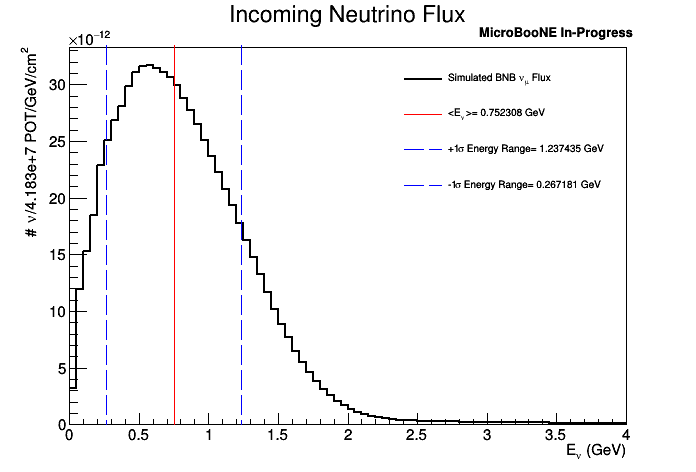

In [3]:
#We're going to calculate our Number of Targest and Neutrino Flux First
######################################################################
rho_Ar = 1.3836; #density of argon in g*cm^-3                                                                      
V = (256.35 - 20.0) * (233.0 - 20.0) * (1036.8 - 20.0);#volume of detector cm: x*y*z                               
N_A = 6.023e+23; #avogadro's number                                                                                
m_mol = 39.95; #mass of argon in g*mol^-1                                                                          
N_targets = (rho_Ar*V*N_A)/m_mol; #number of target nuclei                                                         
#print("Value of Volume: %E cm^3"%V)
print("Value of N_targets assuming 10cm FV border: %E N Targets"%N_targets)

#Neutrino flux stuff
flux_file = ROOT.TFile("../root_files/pelee/Run_all/neutrino_flux.root","READ")
canv_flux = ROOT.TCanvas("canv_flux","canv_flux",700,500)
h_flux = flux_file.Get("hEnumu_cv")
scale_factor= 1/(4997.*5e8)/(256.35*233);
h_flux.Scale(scale_factor)
h_flux.Draw("HIST")

h_flux.GetXaxis().SetRangeUser(0.0,4.0)
h_flux.GetXaxis().SetTitle("E_{#nu} (GeV)")
h_flux.GetYaxis().SetTitle("# #nu/4.183e+7 POT/GeV/cm^{2}")
h_flux.SetTitle("Incoming Neutrino Flux")
g = ROOT.TF1("g","gaus")
fit = h_flux.Fit(g,"Q")
parameters = g.GetParameters() 
ymax = 33.5E-12#h.GetMaximum()

mean = parameters[1]
mean_line = ROOT.TLine(mean,0,mean,ymax)
mean_line.Draw("SAME")
mean_line.SetLineColor(2)
mean_line.SetLineStyle(1)

sigma = parameters[2]
sigma_plus = mean+sigma
sigma_minus = mean-sigma

a_plus = ROOT.TLine(sigma_plus,0,sigma_plus,ymax)
a_plus.Draw("SAME")
a_plus.SetLineColor(4)
a_plus.SetLineStyle(9)

a_minus = ROOT.TLine(sigma_minus,0,sigma_minus,ymax)
a_minus.Draw("SAME")
a_minus.SetLineColor(4)
a_minus.SetLineStyle(9)

legend = ROOT.TLegend(0.57,0.57,0.87,0.87)
legend.AddEntry(h_flux,"Simulated BNB #nu_{#mu} Flux","L")
legend.AddEntry(mean_line,"<E_{#nu}>= %f GeV"%mean,"L")
legend.AddEntry(a_plus,"+1#sigma Energy Range= %f GeV"%sigma_plus,"L")
legend.AddEntry(a_minus,"-1#sigma Energy Range= %f GeV"%sigma_minus,"L")
legend.Draw("SAME")
legend.SetBorderSize(0)
t.DrawLatex(0.8,0.93,"%s"%sample_name)
canv_flux.Draw()

flux_value = (h_flux.Integral()) * pot_num
print("Neutrino Flux Estimate: %E v cm^2"%flux_value)

Now to Grab All the Histograms We Need

In [4]:
############################################################################################
#Now we are going to grab all the histograms that will consistute the numerator of our XSec:
##########################################################################################

#physics quantities
########################
other_var = ["_opening_angle_protons_lab","_opening_angle_protons_com","_opening_angle_mu_leading",
             "_opening_angle_mu_both","_delta_PT","_delta_alphaT","_delta_phiT","_pn","_nu_E"]

#BNB Histograms
f_bnb = ROOT.TFile('../root_files/pelee/Run_all/histograms_pelee_xsec_bnb.root')
h_bnb_particles = []
h_bnb_other = []

#EXT Histograms
f_ext = ROOT.TFile('../root_files/pelee/Run_all/histograms_pelee_xsec_ext.root')
h_ext_particles = []
h_ext_other = []

#Dirt Histograms
f_dirt = ROOT.TFile('../root_files/pelee/Run_all/histograms_pelee_xsec_dirt_wgt.root')
h_dirt_particles = []
h_dirt_other = []
 
#NuWro Histograms
f_nuwro = ROOT.TFile('../root_files/nuwro/Run_all/histograms_nuwro_xsec_overlay_wgt.root')
h_nuwro_particles = []
h_nuwro_other = []

#Overlay Histograms
f_overlay = ROOT.TFile('../root_files/pelee/Run_all/histograms_pelee_xsec_overlay_wgt.root')
channel = ['_total', '_cc2p0pi'] #we only really care about these two
#channel = ['_total', '_cc2p0pi','_ccNp1pi','_ccNp0pi','_cc1p0pi','_nc','_ccNpNpi',
#            '_cc0p0pi','_other','_outfv','_ccnue']
h_overlay_particles_total = []
h_overlay_particles_cc2p = []
h_overlay_other_total = []
h_overlay_other_cc2p = []
h_other_num = [] #num of efficiency histograms
h_other_denom = [] #denom of efficiency histograms

#Efficiency histograms
f_eff = ROOT.TFile('../root_files/pelee/Run_all/histograms_mc_eff.root')
h_other_eff = [] #list of eff for the other variables

#Migration matrices
f_matrices = ROOT.TFile("../root_files/pelee/Run_all/xsec_extraction.root")
h_other_matrices = [] #list of matrices for the other variables

#THE MEC and GCF HIstograms
f_empirical = ROOT.TFile("/Users/ssfehlberg/Research/Thesis/2Proton_Pandora/root_files/MEC/hists_empirical_lwellyn.root")
h_empirical_other = []
f_nieves = ROOT.TFile("/Users/ssfehlberg/Research/Thesis/2Proton_Pandora/root_files/MEC/hists_nieves.root")  
h_nieves_other = []
f_susa = ROOT.TFile("/Users/ssfehlberg/Research/Thesis/2Proton_Pandora/root_files/MEC/hists_susav2.root")
h_susa_other = []
f_GCF = ROOT.TFile("/Users/ssfehlberg/Research/Thesis/2Proton_Pandora/root_files/GCF/hists_GCF_CCQE.root")
h_GCF_other = []

#Now to Grab the histograms
###############################
for i in range(0,len(other_var)):     
    
    #BNB
    hist_bnb = f_bnb.Get('h%s_bnb'%other_var[i]) 
    h_bnb_other.append(hist_bnb)
    
    #EXT
    hist_ext = f_ext.Get('h%s_ext'%other_var[i])
    h_ext_other.append(hist_ext)
    
    #DIRT
    h_dirt = f_dirt.Get('h%s_dirt_wgt'%other_var[i]) #dirt
    h_dirt_other.append(h_dirt) 
    
    #NuWro
    h_nuwro = f_nuwro.Get('h%s%s'%(other_var[i],channel[1]))
    h_nuwro_other.append(h_nuwro)
    
    #OVERLAY
    hist_overlay_total = f_overlay.Get('h%s%s'%(other_var[i],channel[0])) #total MC background
    h_overlay_other_total.append(hist_overlay_total)
    hist_overlay_cc2p = f_overlay.Get('h%s%s'%(other_var[i],channel[1])) #cc2p signal
    h_overlay_other_cc2p.append(hist_overlay_cc2p)
    
    #EFFICIENCY
    hist_num = f_eff.Get('h_other_eff_num%s'%other_var[i]) #numerator
    h_other_num.append(hist_num)
    hist_denom = f_eff.Get('h_other_eff_denom%s'%other_var[i]) #numerator
    h_other_denom.append(hist_denom)
    
    #MIGRATION MATRICES
    h_other_eff.append(f_matrices.Get("h_other_eff_num%s"%other_var[i]))    
    h_other_matrices.append(f_matrices.Get("h_other_matrices%s"%other_var[i]))
    
    #EMPIRICAL
    h_empirical = f_empirical.Get("h%s_lead_cut"%other_var[i])
    h_empirical_other.append(h_empirical)
    
    #NIEVES
    h_nieves = f_nieves.Get("h%s_lead_cut"%other_var[i])
    h_nieves_other.append(h_nieves)
    
    #SUSA
    h_susa = f_susa.Get("h%s_lead_cut"%other_var[i])
    h_susa_other.append(h_susa)
    
    #GCF
    h_GCF = f_GCF.Get("h%s_lead_cut"%other_var[i])
    h_GCF_other.append(h_GCF)

   
print('Finished Grabbing All the Other Histograms')

Finished Grabbing All the Other Histograms


In [5]:
# Alright, let's extract a cross section. 
# Latex Format for XSEC Formula:
#    \sigma_i = 22 \frac{\sum_{j} U(N_j-b_j)}{\epsilon_i\Phi_i N_t}
# 
#  Or, more explicitly:
#
# 
# The CrossSection in Energy Bin i is calculated by:
# 1) Taking the Data Events selected in reco energy bin j
# 2) Subtracting away the background events in reco energy bin j.
# 3) Take the remaining events, and 'unfold' (U) them in order
# to undo the true->reco energy smearing, while summing up contributions
# from all reco energy bins j. This is entirely handled by RooUnfold
# 4) Next divide by the efficiency of selecting the signal event in 
# true energy bin i to get the number of signal events that occurred, 
# not just the ones we found.
# 5) Divide by the (NuMu Flux)*(POT)*(Neutrons in Target) to get 
# Cross Section Per Neutron
# 6) Multiply by 22 neutrons/argon to get Cross Section per Argon Nucleus
# 7) Celebrate!!!

Number of Entries in h_overlay: 4485.926403325726
Number of Entries in h_overlay_cc2p: 3063.3076496808476
Number of Entries in h_overlay: 1422.6187536448776
Num entries in h_ext: 105.17099999999999
Num entries in h_dirt: 11.723508300454244
Num entries in h_overlay: 1422.6187536448776
Num entries in h_ext after work: 1539.513261945332


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c6


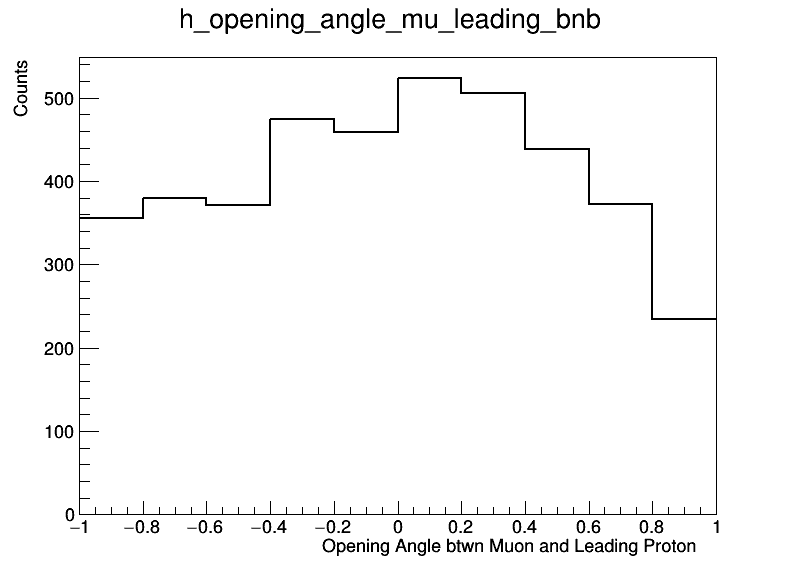

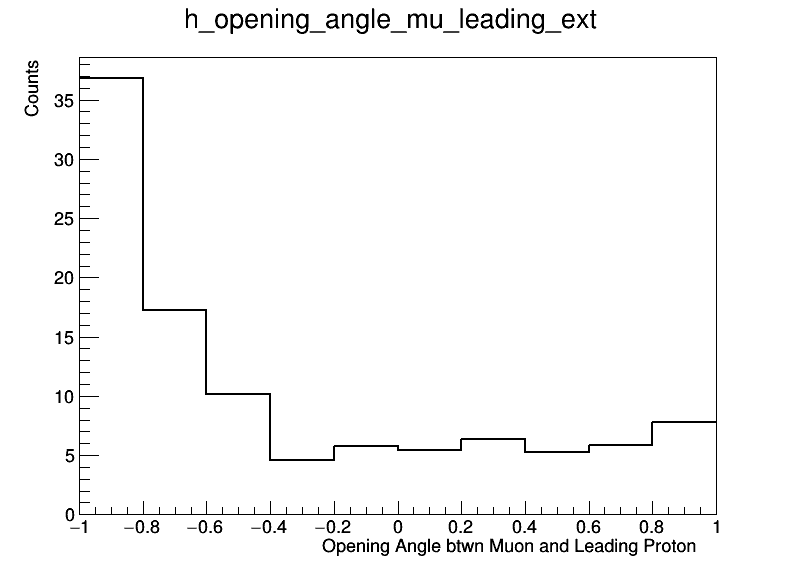

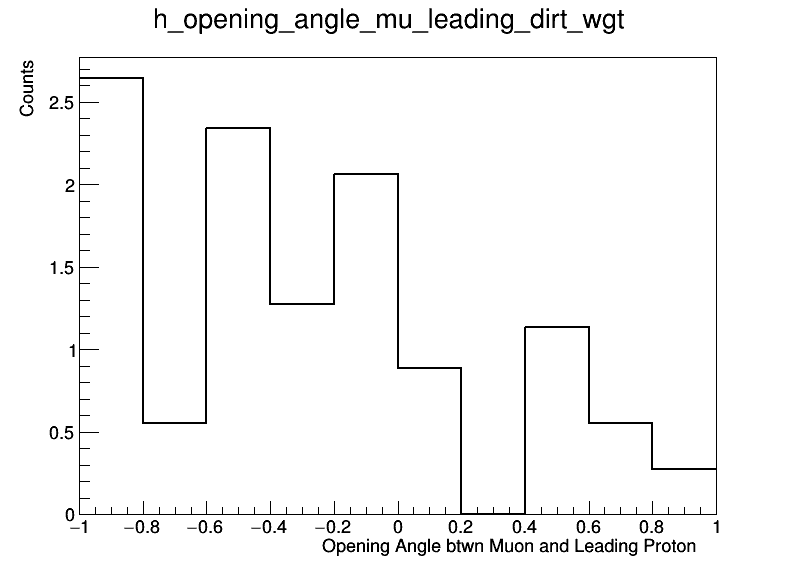

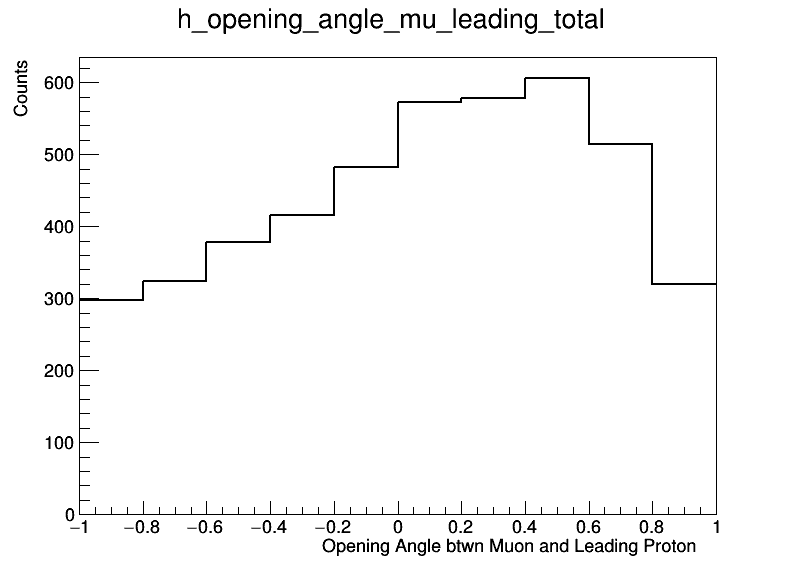

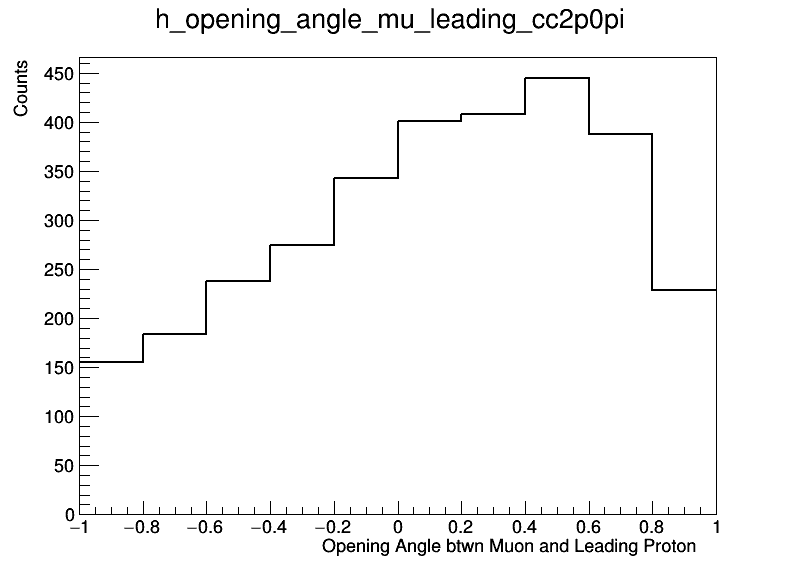

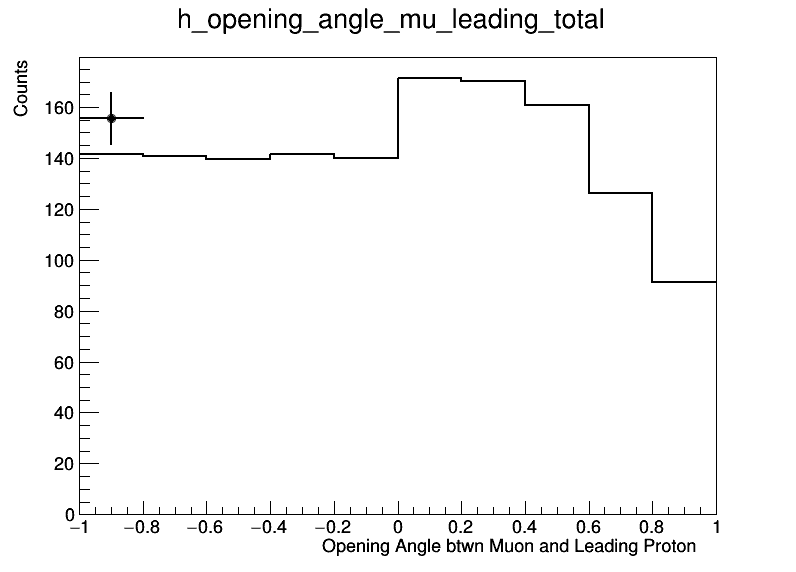

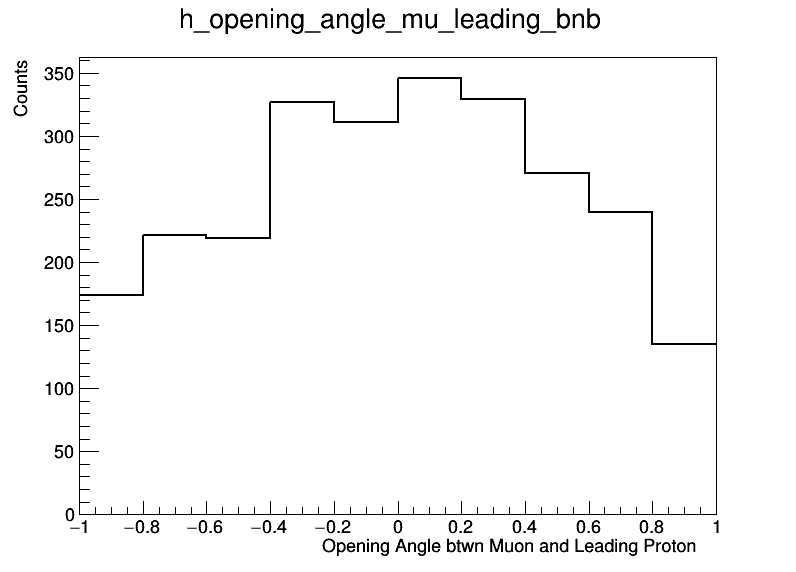

In [6]:
"""
Steps 1 and 2: Subtract the Expected Background from the Data.
"""

#BNB Data
#########
c0 = ROOT.TCanvas("c0","BNB Before Subtraction",800,600) #you have to define a canvas to draw. 
h_bnb0 = h_bnb_other[2].Clone("h_bnb0%s"%other_var[2])
h_bnb0.Draw("hist")
c0.Draw()

#Background
###########

#ext
c1 = ROOT.TCanvas("c1","Raw EXT",800,600) #you have to define a canvas to draw. 
h_ext0 = h_ext_other[2].Clone("h_ext0%s"%other_var[2]) #ext background
h_ext0.Draw("HIST")
c1.Draw()

#Dirt
c2 = ROOT.TCanvas("c2","Raw Dirt",800,600) #you have to define a canvas to draw.
h_dirt0 = h_dirt_other[2].Clone("h_dirt0%s"%other_var[2]) #dirt background
h_dirt0.Draw("hist")
c2.Draw()

#Raw Overlay
c3 = ROOT.TCanvas("c3","Overlay Total",800,600) #you have to define a canvas to draw.
h_overlay_total0 = h_overlay_other_total[2].Clone("h_overlay_total0%s"%other_var[2]) #overlay background
h_overlay_total0.Draw("hist")
c3.Draw()

#CC2p Overlay
c4 = ROOT.TCanvas("c4","Overlay CC2p",800,600) #you have to define a canvas to draw.
h_overlay_cc2p0 = h_overlay_other_cc2p[2].Clone("h_overlay_cc2p0%s"%other_var[2])
h_overlay_cc2p0.Draw("hist")
c4.Draw()

#Total Overlay - CC2p Overlay
c5 = ROOT.TCanvas("c5","Overlay Subtracted",800,600) #you have to define a canvas to draw.

h_overlay_total2 = h_overlay_other_total[2].Clone("h_overlay_total2%s"%other_var[2]) #overlay background
print("Number of Entries in h_overlay: %s"%h_overlay_total2.Integral())

h_overlay_cc2p = h_overlay_other_cc2p[2].Clone("h_overlay_cc2p%s"%other_var[2])
print("Number of Entries in h_overlay_cc2p: %s"%h_overlay_cc2p.Integral())

h_overlay_total2.Add(h_overlay_cc2p, -1) # make sure to taake the cc2p out of the total
print("Number of Entries in h_overlay: %s"%h_overlay_total2.Integral())
h_overlay_total2.Draw("hist")
h_overlay_total0.Draw("SAME")
h_overlay_cc2p.Draw("SAME")
c5.Draw()

#add the backgrounds together
c6 = ROOT.TCanvas("c6","Total Background",800,600) #you have to define a canvas to draw.
h_ext = h_ext_other[2].Clone("h_ext%s"%other_var[2]) #ext background
print("Num entries in h_ext: %s"%h_ext.Integral())
h_dirt = h_dirt_other[2].Clone("h_dirt%s"%other_var[2]) #dirt background
print("Num entries in h_dirt: %s"%h_dirt.Integral())
h_ext.Add(h_dirt)
print("Num entries in h_overlay: %s"%h_overlay_total2.Integral())
h_ext.Add(h_overlay_total2)
h_ext.Draw("hist")
print("Num entries in h_ext after work: %s"%h_ext.Integral())
c6.Draw()
#print("Num entries in h_ext: %s"%h_ext.Integral())
#print("Num Entries in h_overlay_other_cc2p[2]: %s"%h_overlay_other_cc2p[2].Integral())

#The Subtraction and Draw it
###############################
c6 = ROOT.TCanvas("c6","BNB with Background Subtracted",800,600) #you have to define a canvas to draw.
h_bnb = h_bnb_other[2].Clone("h_bnb%s"%other_var[2])
h_bnb.Add(h_ext,-1)
h_bnb.Draw("HIST")
c6.Draw()

Here is where we do the Closure Test

Now unfolding...
Iteration : 0
Chi^2 of change 8.88314
Calculating covariances due to number of measured events


Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for src/RooUnfold.h
   requested to autoload type RooUnfoldResponse
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for src/RooUnfold.h
   requested to autoload type RooUnfold
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for src/RooUnfoldBayes.h
   requested to autoload type RooUnfoldBayes
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for src/RooUnfoldBinByBin.h
   requested to autoload type RooUnfoldBinByBin
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for src/RooUnfoldErrors.h
   requested to autoload type RooUnfoldErrors
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing FileEntry for src/RooUnfoldIds.h
   requested to autoload type RooUnfoldIds
Error in cling::AutoloadingVisitor::InsertIntoAutoloadingState:
   Missing Fil

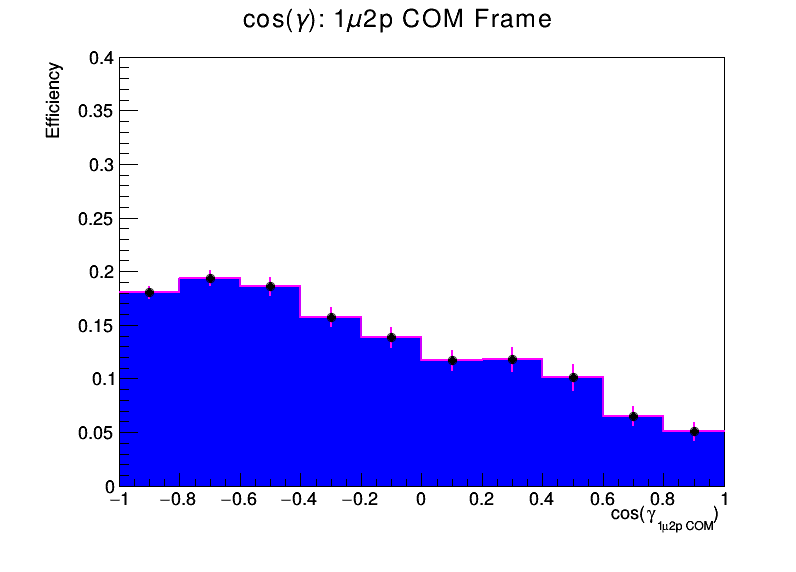

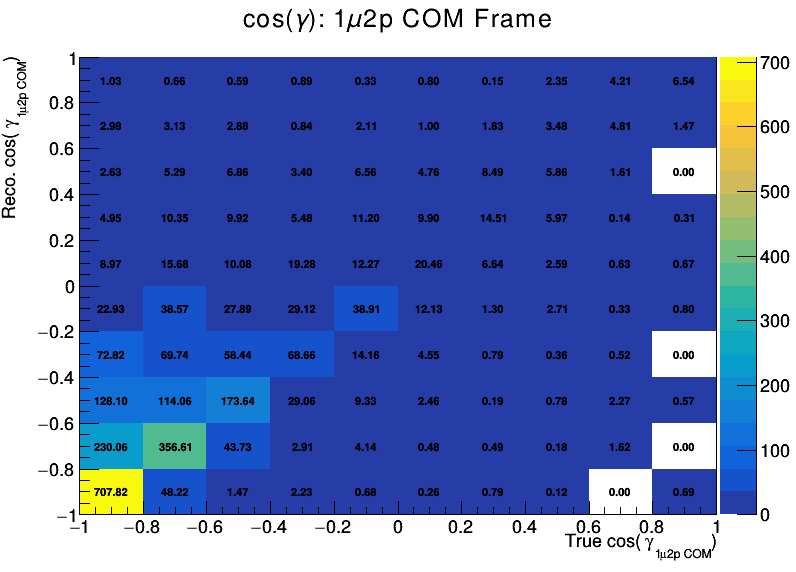

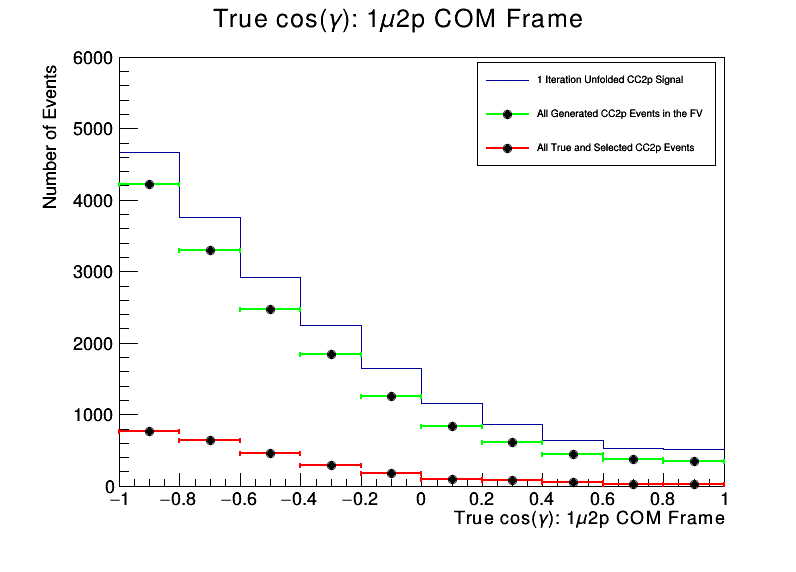

In [7]:
################################################################
#Here we do A Closure Test with The MC truth Acting As Our Data
###############################################################

#Some weird things:
#############################
plot =  1#which variable to plot
other_titles= [r'\mathrm{cos}(\gamma)\text{ :Lab Frame}',r'\mathrm{cos}(\gamma)\text{: 1}\mu\text{2p COM Frame}}}',
               r'\mathrm{cos}(\gamma_{\mu,p_{L}})', r'\mathrm{cos}(\gamma_{\mu,p_{L}+p_{R}})',
               r'\delta \mathrm{P}_{\mathrm{T}} \text{ (GeV/c)}',r'\delta \alpha_{\mathrm{T}} \text{ (Deg.)}',
               r'\delta \phi_{\mathrm{T}}\text{ (Deg.)}',r'\mathrm{p}_{\mathrm{n}} \text{(GeV/c)}',r'\text{Neutrino Energy (GeV)}'] #titles for root
other_max = [4000,6000,4000,4500,10000,9000,15000,12000,4500]

#Check the Efficiency Histogram
###############################
c_eff = ROOT.TCanvas("c_eff","Efficiency",800,600)
c_eff.SetRightMargin(0.09)
c_eff.SetLeftMargin(0.15)
c_eff.SetBottomMargin(0.15)
#eff from xsec prep
h_other_eff[plot].Draw("HIST") 
h_other_eff[plot].SetFillColor(ROOT.kBlue)
h_other_eff[plot].SetTitle(other_titles[plot])
h_other_eff[plot].SetMaximum(0.4)
#sanity check of xsec prep eff
h_num_eff = h_other_num[plot].Clone() 
h_denom_eff = h_other_denom[plot].Clone()
h_num_eff.Divide(h_num_eff,h_denom_eff,1,1,"cp")
h_num_eff.Draw("p SAME")
h_num_eff.SetLineColor(ROOT.kMagenta)
c_eff.Draw()

#Make Sure the Smearing Matrix is Okay
######################################
c_2d =  ROOT.TCanvas("c_2d","Smearing Matrix",800,600) #you have to define a canvas to draw. 
h_smearing = h_other_matrices[plot].Clone()
h_smearing.Draw("colz text")
h_smearing.SetTitle(other_titles[plot])
c_2d.Draw()

#Now to actually perform the closure test and plot it.
###############################################################
Closure_Response_Matrix = ROOT.RooUnfoldResponse(0,0,h_smearing,"ClosureResponseMatrix")
#ROOT.RooUnfoldResponse.UseOverflow(Closure_Response_Matrix,ROOT.kFALSE)
RooUnfoldBayes_MC = ROOT.RooUnfoldBayes(Closure_Response_Matrix,h_overlay_other_cc2p[plot], 1)
error_method = 1
h_unfolded_signal_closure = RooUnfoldBayes_MC.Hreco(error_method)
    
c_closure = ROOT.TCanvas("c_closure","Closure Test",800,600)
c_closure.SetRightMargin(0.09)
c_closure.SetLeftMargin(0.15)
c_closure.SetBottomMargin(0.15)
h_closure = h_unfolded_signal_closure.Clone()
h_closure.Draw("hist")

#divide by efficiency
h_closure.Divide(h_unfolded_signal_closure,h_other_eff[plot],1,1,"cp")
 
#Drawing Effieicny on Same Plot
h_other_denom[plot].Draw("SAME 1e1p") 
h_other_denom[plot].SetLineColor(ROOT.kGreen)
h_other_num[plot].Draw("SAME 1e1p")
h_other_num[plot].SetLineColor(ROOT.kRed)

#Stupid setting parameters
h_closure.SetMaximum(other_max[plot])
h_closure.SetTitle(r'\text{True }%s'%other_titles[plot])
h_closure.GetXaxis().SetTitle(r'\text{True }%s'%other_titles[plot])
h_closure.GetYaxis().SetTitle("Number of Events")
legend_closure = ROOT.TLegend(0.6, 0.71, 0.899, 0.89)
legend_closure.AddEntry(h_closure,"1 Iteration Unfolded CC2p Signal","lpf")
legend_closure.AddEntry(h_other_denom[plot],"All Generated CC2p Events in the FV","lpf")
legend_closure.AddEntry(h_other_num[plot],"All True and Selected CC2p Events","lpf")
legend_closure.Draw()
c_closure.Draw()

We are going to subtract the background here to create our h_bnb (signal) histogram.

Num entries in h_ext: 105.171
Num entries in h_dirt: 11.723508300454245
Num entries in h_ext After Adding Dirt: 116.89450830045426
Number of Entries in h_overlay: 4485.926403325742
Number of Entries in h_overlay_cc2p: 3063.3076496808512
Num entries in h_overlay after Subtraction: 1422.6187536448929
Num entries in h_ext after everything: 1539.5132619453466
Num entries in h_bnb: 4112.0
Num entries in h_bnb After Subtraction: 2572.486738054653


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c6
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c6


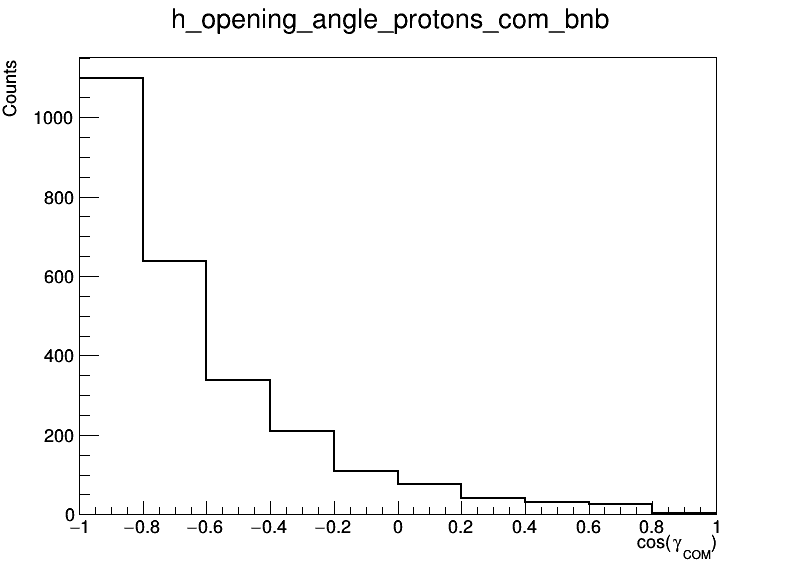

In [8]:
#General Stuff we Need for plotting
#####################################
other_titles= [r'\mathrm{True}\ \mathrm{cos}($\gamma_\mathrm{Lab}$)',r'\mathrm{True}\ \mathrm{cos}($\gamma_{1\mu2p \ COM}$)',
               r'\mathrm{True}\ \mathrm{cos}($\gamma_{\mu,p_{L}}$)', r'\mathrm{True}\ \mathrm{cos}($\gamma_{\mu,p_{L}+p_{R}}$)',
               r'$\delta \mathrm{P}_{\mathrm{T}}$ \mathrm{(GeV/c)}',r'$\delta \alpha_{\mathrm{T}}$ \mathrm{(Deg.)}',
               r'$\delta \phi_{\mathrm{T}}$ \mathrm{(Deg.)}',r'\mathrm{p}_{\matrm{n}} \text{(GeV/c)}',r'True Neutrino Energy (GeV)'] #titles for root
other_max = [600,8000,3500,4500,12000,1600,1600,1500,1500] #maximum of the plots
colors = [ROOT.kBlue,ROOT.kRed, ROOT.kGreen, 
          ROOT.kCyan, ROOT.kBlack, ROOT.kOrange, 
          ROOT.kYellow, ROOT.kAzure,ROOT.kSpring] #colors for the iteration test

#Defining histograms for later
###############################
h_eff = h_other_eff[plot].Clone("h_eff_unfold") #efficiency 
h_smearing = h_other_matrices[plot].Clone("h_smearing_unfold") #smearing matrix
h_denom = h_other_denom[plot].Clone("h_overlay_unfold")#what we will compare to

#Defining stuff for the unfolding
#################################
Response_Matrix = ROOT.RooUnfoldResponse(0,0,h_smearing) #the response matrix
error_method = 2 #error method to use: 2 is kcovariance error propogation, 1 is binbybin error, and 0 is no error

#Creating the Background: add the backgrounds together: h_ext is what we will subtract
########################################################################################
c_background = ROOT.TCanvas("c6","Total Background",800,600) #you have to define a canvas to draw.
h_ext = h_ext_other[plot].Clone("h_ext%s"%other_var[2]) #ext background
print("Num entries in h_ext: %s"%h_ext.Integral())
h_dirt = h_dirt_other[plot].Clone("h_dirt%s"%other_var[2]) #dirt background
print("Num entries in h_dirt: %s"%h_dirt.Integral())
h_ext.Add(h_dirt)
print("Num entries in h_ext After Adding Dirt: %s"%h_ext.Integral())
h_overlay_total2 = h_overlay_other_total[plot].Clone("h_overlay_total2%s"%other_var[2]) #overlay background
print("Number of Entries in h_overlay: %s"%h_overlay_total2.Integral())
h_overlay_cc2p = h_overlay_other_cc2p[plot].Clone("h_overlay_cc2p%s"%other_var[2])
print("Number of Entries in h_overlay_cc2p: %s"%h_overlay_cc2p.Integral())
h_overlay_total2.Add(h_overlay_cc2p, -1) # make sure to taake the cc2p out of the total
print("Num entries in h_overlay after Subtraction: %s"%h_overlay_total2.Integral())
h_ext.Add(h_overlay_total2)
print("Num entries in h_ext after everything: %s"%h_ext.Integral())
h_ext.Draw("HIST")
c_background.Draw()

#Draw the subtracted backgrounds as a check
c6 = ROOT.TCanvas("c6","BNB with Background Subtracted",800,600) #you have to define a canvas to draw.
h_bnb = h_bnb_other[plot].Clone("h_bnb%s"%other_var[plot])
print("Num entries in h_bnb: %s"%h_bnb.Integral())
h_bnb.Add(h_ext,-1)
print("Num entries in h_bnb After Subtraction: %s"%h_bnb.Integral())
h_bnb.Draw("HIST")
c6.Draw()

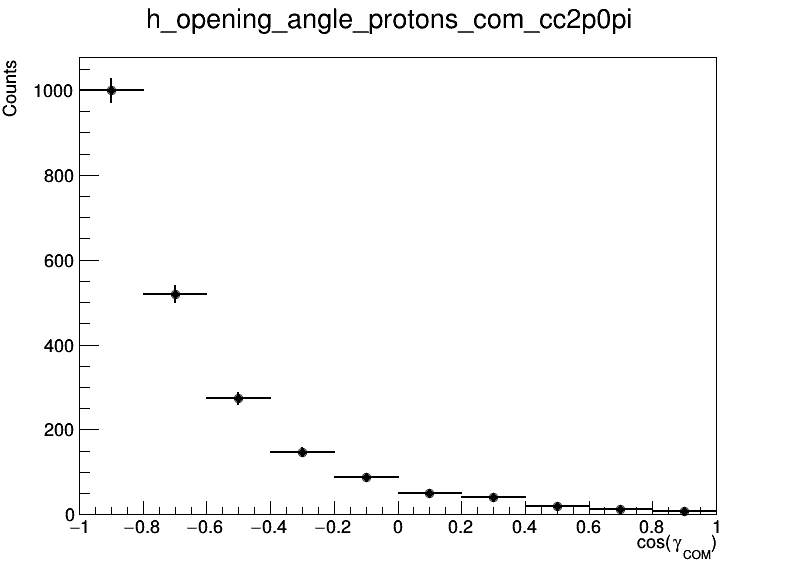

In [9]:
canv_test = ROOT.TCanvas("canv_test","",800,600)
h_nuwro_other[plot].Draw()
canv_test.Draw()

This is where we perform our Iteration Test Using the NuFACT Data as Fake Data

STARTING THE ITERATION TEST
Now unfolding...
Iteration : 0
Chi^2 of change 0.844482
Calculating covariances due to number of measured events
Now unfolding...
Iteration : 0
Chi^2 of change 0.844482
Iteration : 1
Chi^2 of change 0.432717
Calculating covariances due to number of measured events
Now unfolding...
Iteration : 0
Chi^2 of change 0.844482
Iteration : 1
Chi^2 of change 0.432717
Iteration : 2
Chi^2 of change 0.24338
Calculating covariances due to number of measured events
Now unfolding...
Iteration : 0
Chi^2 of change 0.844482
Iteration : 1
Chi^2 of change 0.432717
Iteration : 2
Chi^2 of change 0.24338
Iteration : 3
Chi^2 of change 0.144806
Calculating covariances due to number of measured events
Now unfolding...
Iteration : 0
Chi^2 of change 0.844482
Iteration : 1
Chi^2 of change 0.432717
Iteration : 2
Chi^2 of change 0.24338
Iteration : 3
Chi^2 of change 0.144806
Iteration : 4
Chi^2 of change 0.0896192
Calculating covariances due to number of measured events
Now unfolding...
It

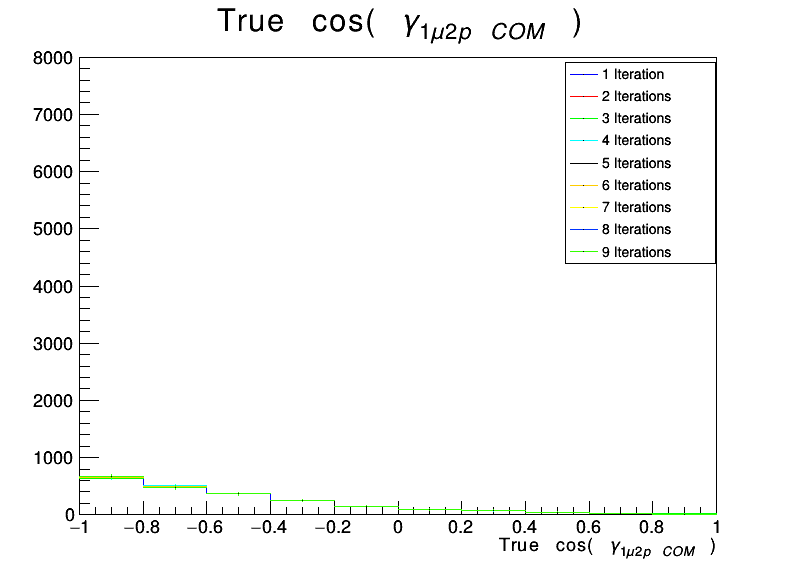

In [10]:
#Time to Perform an Iteration Test
################################
print("STARTING THE ITERATION TEST")
iterations_test = 8 #number of iterations

h_nuwro = h_nuwro_other[plot].Clone()

RooUnfoldBayes_Test = ROOT.RooUnfoldBayes(Response_Matrix, h_nuwro, iterations_test);

RooUnfoldBayes_Data = []
RooUnfoldBayes_Data.append(ROOT.RooUnfoldBayes(Response_Matrix, h_nuwro,1));

h_unfolded_signal_test = []
h_unfolded_signal_test.append(RooUnfoldBayes_Data[0].Hreco(error_method))

h_xsec_test = []
c_xsec_test = ROOT.TCanvas("c_xsec_test","iteration 1",800,600)
h_xsec_test.append(h_unfolded_signal_test[0].Clone())
h_xsec_test[0].Draw("HIST")
h_xsec_test[0].SetLineColor(colors[0])
h_xsec_test[0].SetMaximum(other_max[plot])
h_xsec_test[0].SetTitle(r'\text{}%s'%other_titles[plot])
h_xsec_test[0].GetXaxis().SetTitle(r'\text{}%s'%other_titles[plot])
legend_test = ROOT.TLegend(0.71, 0.54, 0.899, 0.89)
legend_test.AddEntry(h_xsec_test[0],"1 Iteration","lpf")

for i in range(1,iterations_test+1):
    RooUnfoldBayes_Data.append(ROOT.RooUnfoldBayes(Response_Matrix, h_nuwro, i+1));
    h_unfolded_signal_test.append(RooUnfoldBayes_Data[i-1].Hreco(error_method)) # the unfolded data
    h_unfolded_signal_test[i-1].Draw("SAME")
    h_unfolded_signal_test[i-1].SetLineColor(colors[i])
    legend_test.AddEntry(h_unfolded_signal_test[i-1],"%s Iterations "%(i+1),"lpf")
    
legend_test.Draw("SAME")
c_xsec_test.Draw()    

In [11]:
#This is for our chi2 test
#############################
iterations_test = 3
chi2_vector = []
h_truth = h_other_denom[plot].Clone()
n_bins = h_truth.GetNbinsX()
iterations_vector = [] #number of iterations as a function of number of plots

for x in range(1,iterations_test+1):
    
    unfolded_observed = ROOT.RooUnfoldBayes(Closure_Response_Matrix, h_nuwro, x)
    h_observed = unfolded_observed.Hreco(error_method)
    
    chi2 = 0.0
    for i in range(1,n_bins+1):
        O_i = h_observed.GetBinContent(i)
        E_i = h_truth.GetBinContent(i)    

        if(O_i == 0 and E_i == 0):
            chi2 += 0.0
        elif(E_i == 0):
            chi2 += 0.0
        else:
            chi2 += np.square(O_i - E_i)/E_i
    
    print("-----------------------------------")
    print("Number of Iterations: %f"%(x))
    print("Number of Bins: %f"%n_bins)
    print("Chi2 of the Difference: %f"%chi2)
    print("Chi2/D.o.F.%f"%(chi2/n_bins))
    print("----------------------------------- \n")
    chi2_vector.append(chi2/n_bins)
    
for i in range(0,len(chi2_vector)-1):
    delta_chi2 = chi2_vector[i+1] - chi2_vector[i]
    print("////////////")
    print("Delta Chi2 between %f and %f iterations: %f"%((i+2),(i+1),delta_chi2))
    print("//////////// \n")
    
    if(delta_chi2 < 1.0):
        iterations_vector.append(i+1)
        
print("--------")
print("Smallest Number of Iterations Needed: %s"%iterations_vector[0])
print("--------\n")  

-----------------------------------
Number of Iterations: 1.000000
Number of Bins: 10.000000
Chi2 of the Difference: 11683.890358
Chi2/D.o.F.1168.389036
----------------------------------- 

-----------------------------------
Number of Iterations: 2.000000
Number of Bins: 10.000000
Chi2 of the Difference: 11682.987409
Chi2/D.o.F.1168.298741
----------------------------------- 

-----------------------------------
Number of Iterations: 3.000000
Number of Bins: 10.000000
Chi2 of the Difference: 11682.580937
Chi2/D.o.F.1168.258094
----------------------------------- 

////////////
Delta Chi2 between 2.000000 and 1.000000 iterations: -0.090295
//////////// 

////////////
Delta Chi2 between 3.000000 and 2.000000 iterations: -0.040647
//////////// 

--------
Smallest Number of Iterations Needed: 1
--------

Now unfolding...
Iteration : 0
Chi^2 of change 0.844482
Calculating covariances due to number of measured events
Now unfolding...
Iteration : 0
Chi^2 of change 0.844482
Iteration : 1
Chi

Before we can draw everything, we have to create the MEC and GCF plots to plot on the BNB plot

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canv_theory


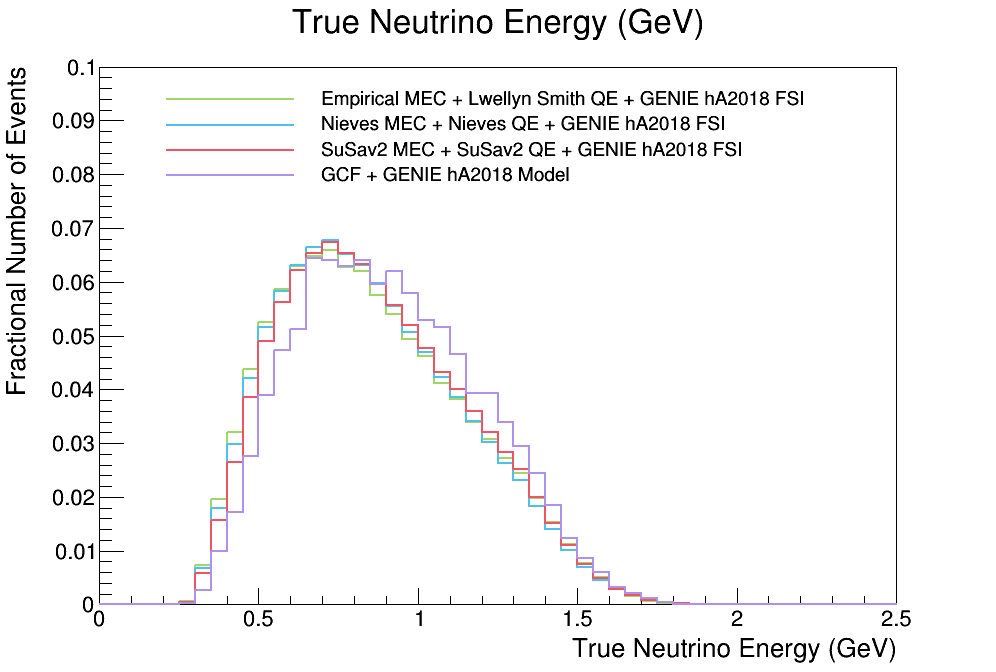

In [19]:
#Drawing all the theory models on the same plot
####################################

plot = 8

max = [0.1,0.25,0.1,0.1,0.25,0.25,0.55,0.4,0.1]

h_empirical = h_empirical_other[plot].Clone()
h_nieves = h_nieves_other[plot].Clone()
h_susa = h_susa_other[plot].Clone()
h_GCF = h_GCF_other[plot].Clone()
h_GCF.Scale(N_targets*flux_value)

#time to area normalize
n_bins = h_empirical.GetNbinsX()
empirical_integral = h_empirical.Integral()
nieves_integral = h_nieves.Integral()
susa_integral = h_susa.Integral()
GCF_integral = h_GCF.Integral()

for i in range(1,n_bins+1):
    empirical_bin_content = h_empirical.GetBinContent(i)
    empirical_value = empirical_bin_content/empirical_integral
    h_empirical.SetBinContent(i,empirical_value)
    
    
    nieves_bin_content = h_nieves.GetBinContent(i)
    nieves_value = nieves_bin_content/nieves_integral
    h_nieves.SetBinContent(i,nieves_value)
    
    susa_bin_content = h_susa.GetBinContent(i)
    susa_value = susa_bin_content/susa_integral
    h_susa.SetBinContent(i,susa_value)
    
    GCF_bin_content = h_GCF.GetBinContent(i)
    GCF_value = GCF_bin_content/GCF_integral
    h_GCF.SetBinContent(i,GCF_value)
                   
#Now to do the actual drawing
##################
color0 = ROOT.kBlack
color1 = ROOT.TColor.GetColor("#FFCE54") #yellow
color2 = ROOT.TColor.GetColor("#A0D568") #green
color3 = ROOT.TColor.GetColor("#4FC1E8") #blue
color4 = ROOT.TColor.GetColor("#ED5564") #red
color5 = ROOT.TColor.GetColor("#AC92EB") #purple

canv_theory = ROOT.TCanvas("canv_theory","canv_theory",1000,700)

h_empirical.Draw("hist")
h_empirical.SetLineColor(color2)
h_empirical.SetTitle("%s"%other_titles[plot])
h_empirical.SetXTitle("%s"%other_titles[plot])
h_empirical.GetXaxis().SetTitleSize(28)
h_empirical.GetXaxis().SetTitleFont(43)
h_empirical.SetYTitle("Fractional Number of Events")
h_empirical.GetYaxis().SetTitleSize(28)
h_empirical.GetYaxis().SetTitleFont(43)
h_empirical.SetMaximum(max[plot])


h_nieves.Draw("hist same")
h_nieves.SetLineColor(color3)

h_susa.Draw("hist same")
h_susa.SetLineColor(color4)

h_GCF.Draw("hist same")
h_GCF.SetLineColor(color5)

legend_theory = ROOT.TLegend(0.14, 0.72, 0.87, 0.87)
#legend_theory.SetNColumns(2)
#legend_theory.AddEntry(h_empirical,"#splitline{Empirical MEC + Lwellyn Smith QE}{with FSI (GENIE hA2018 Model)}","L")
#legend_theory.AddEntry(h_nieves,"#splitline{Nieves MEC & QE with FSI}{(GENIE hA2018 Model)}","L")
#legend_theory.AddEntry(h_susa,"#splitline{SuSav2 MEC & QE with FSI}{(GENIE hA2018 Model)}","L")
#legend_theory.AddEntry(h_GCF,"#splitline{GCF with FSI}{(GENIE hA2018 Model)}","L") 

legend_theory.AddEntry(h_empirical,"Empirical MEC + Lwellyn Smith QE + GENIE hA2018 FSI","L")
legend_theory.AddEntry(h_nieves,"Nieves MEC + Nieves QE + GENIE hA2018 FSI","L")
legend_theory.AddEntry(h_susa,"SuSav2 MEC + SuSav2 QE + GENIE hA2018 FSI","L")
legend_theory.AddEntry(h_GCF,"GCF + GENIE hA2018 Model","L") 
legend_theory.SetLineWidth(0);
legend_theory.SetFillColor(ROOT.kWhite);
legend_theory.SetTextSize(0.03);
legend_theory.Draw("SAME")

canv_theory.Draw()

In [13]:
#Before we can plot the MEC models on the same plot as the BNB, we have to "normalize" using the procedure outlined
# in section 7.4 of this document: https://arxiv.org/pdf/2101.11867.pdf
# We are specifically refering to equations 98: MC Estimate of the XSec and 99: The SD of this calculation
# (98) dsigma/dx = <sigma> * n/ (N* deltax) 
#where deltax is bin width, n is # of events in a bin, N is total # of events, and sigma is the flux weighted xsec
#(99) SD(dsigma/dx) = <sigma>/(deltax * N) * (((N-n)n)/N)^(1/2)

#here are the sigmas. Taken from the GENIE splines

#stevens values
sigma_empirical = 3.02249 * 1E-37
sigma_nieves = 2.70266 * 1E-37

#me values
#sigma_nieves = 2.71682 * 1E-37 
sigma_susa = 3.81417 * 1E-37

#N is the total number of events generated in each MEC type
N_empirical = 4000000
N_nieves = 2400000
N_susa = 3800000
N_GCF = 500000

#Here is were we calculate the dsigma/dx and the SD of dsigma/dx
n_bins = h_empirical_other[plot].GetNbinsX()
for i in range(1,n_bins+1):
    
    delta_x = h_empirical_other[plot].GetBinWidth(i)
    
    #empirical
    n_empirical = h_empirical_other[plot].GetBinContent(i)
    value_empirical = (sigma_empirical * n_empirical)/( N_empirical * delta_x)
    SD_empirical = (sigma_empirical)/(delta_x*N_empirical) * np.sqrt(((N_empirical - n_empirical)*n_empirical)/(N_empirical))
    h_empirical_other[plot].SetBinContent(i,value_empirical)
    h_empirical_other[plot].SetBinError(i,SD_empirical)
    
    #nieves
    n_nieves = h_nieves_other[plot].GetBinContent(i)
    value_nieves = (sigma_nieves * n_nieves)/(N_nieves * delta_x)
    SD_nieves = (sigma_nieves)/(delta_x*N_nieves) * np.sqrt(((N_nieves - n_nieves)*n_nieves)/(N_nieves))
    h_nieves_other[plot].SetBinContent(i,value_nieves)
    h_nieves_other[plot].SetBinError(i,SD_nieves)
    
    #susa
    n_susa = h_susa_other[plot].GetBinContent(i)
    value_susa = (sigma_susa * n_susa)/(N_susa * delta_x)
    SD_susa = (sigma_susa)/(delta_x*N_susa) * np.sqrt(((N_susa - n_susa)*n_susa)/(N_susa))
    h_susa_other[plot].SetBinContent(i,value_susa)
    h_susa_other[plot].SetBinError(i,SD_susa)
                                                                           
    #Dealing with the GCF is a bit trickier
    #Each event in the GCF is assigned a weight which modifies the CCQE differential cross section
    #While we hav
    n_GCF = h_GCF_other[plot].GetBinContent(i) 
    value_GCF = (n_GCF)/(N_GCF*delta_x)
    SD_GCF = (1)/(delta_x*N_GCF) * np.sqrt(((N_GCF - n_GCF)*n_GCF)/(N_GCF))
    h_GCF_other[plot].SetBinContent(i,value_GCF)
    h_GCF_other[plot].SetBinError(i,SD_GCF)

NOW TO PERFORM THE UNFOLDING

BEGINING THE UNFOLDING FOR THE BNB
FINISHED THE UNFOLDING
Number of Bins: 10.000000
Bin Content: 7.24536e-39
Bin Width: 0.200000
Bin Content: 5.91048e-39
Bin Width: 0.200000
Bin Content: 4.69306e-39
Bin Width: 0.200000
Bin Content: 3.59712e-39
Bin Width: 0.200000
Bin Content: 2.11765e-39
Bin Width: 0.200000
Bin Content: 1.39441e-39
Bin Width: 0.200000
Bin Content: 1.08739e-39
Bin Width: 0.200000
Bin Content: 7.27117e-40
Bin Width: 0.200000
Bin Content: 4.28213e-40
Bin Width: 0.200000
Bin Content: 3.29782e-40
Bin Width: 0.200000
Now unfolding...
Iteration : 0
Chi^2 of change 5.9642
Iteration : 1
Chi^2 of change 1.87777
Calculating covariances due to number of measured events


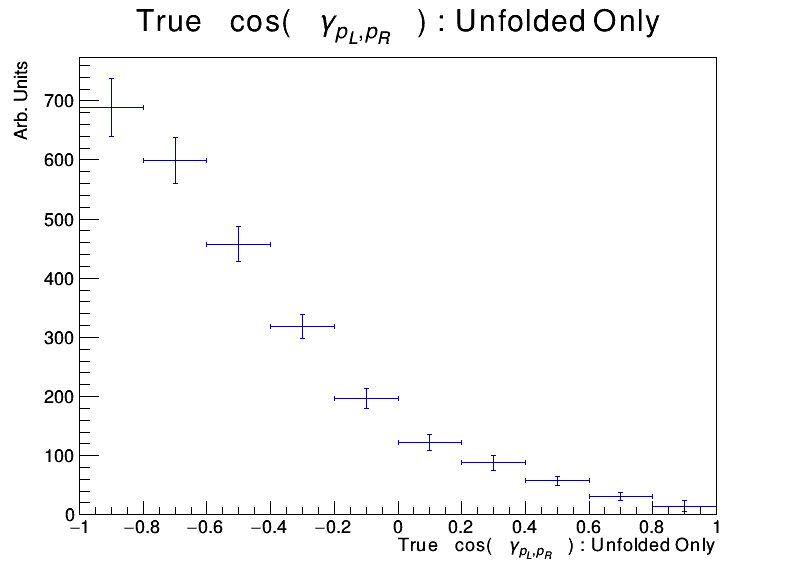

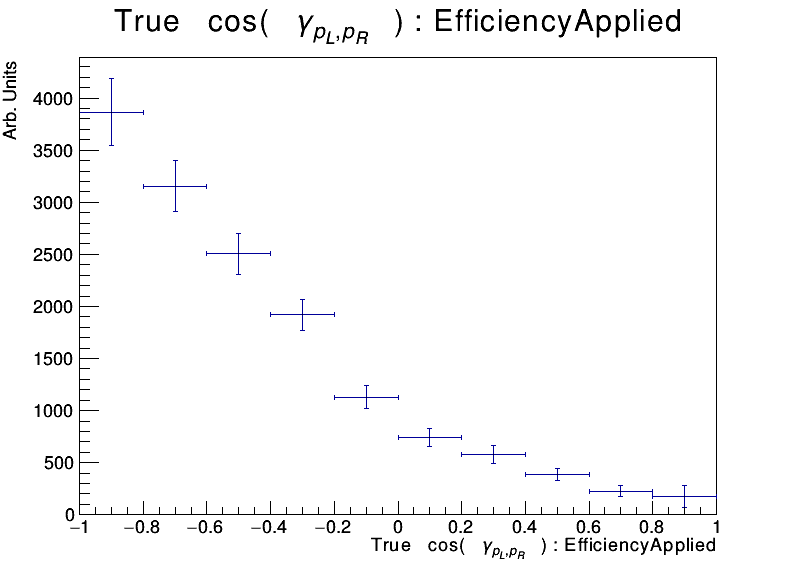

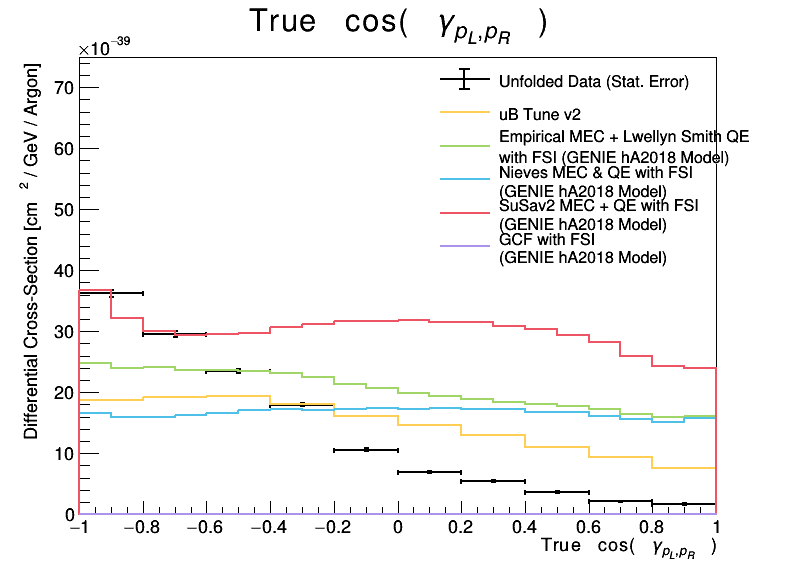

In [14]:
####################################
#Now For the Real Thing!
###########################################
# Brief note: This tutorial uses Bayes/D'Agostini as the method of unfolding. RooUnfold features 
# two other methods of unfolding that can easily be substituted in: BinByBin Unfolding, and 
# Singular Value Decomposition (SVD) Unfolding:
# kterm = 4
# RooUnfoldSVD_Data = ROOT.RooUnfoldSvd(Response_Matrix, Data_Minus_Background_h, kterm);
print("BEGINING THE UNFOLDING FOR THE BNB")
iterations = 2 # number of times to run the bayes unfolding
RooUnfoldBayes_Data = ROOT.RooUnfoldBayes(Response_Matrix, h_bnb, iterations);
h_unfolded_signal =RooUnfoldBayes_Data.Hreco(error_method)
print("FINISHED THE UNFOLDING")

#######################
#Now To Draw Everything
###########################

other_max = [75E-39,0.5E-36,5E-38,8E-38,0.2E-36,1.3E-39,0.9E-39,100E-38,0.06E-36]
color0 = ROOT.kBlack
color1 = ROOT.TColor.GetColor("#FFCE54") #yellow
color2 = ROOT.TColor.GetColor("#A0D568") #green
color3 = ROOT.TColor.GetColor("#4FC1E8") #blue
color4 = ROOT.TColor.GetColor("#ED5564") #red
color5 = ROOT.TColor.GetColor("#AC92EB") #purple

#Defining histograms for later
h_eff = h_other_eff[plot].Clone("h_eff_unfold") #efficiency 
h_smearing = h_other_matrices[plot].Clone("h_smearing_unfold") #smearing matrix
h_denom = h_other_denom[plot].Clone("h_overlay_unfold")#what we will compare to

#Draw one without the constants applied
#######################################
c_xsec_no_const = ROOT.TCanvas("c_xsec_no_const","Unfolded Data ONLY",800,600)
h_xsec_no_const = h_unfolded_signal.Clone();
h_xsec_no_const.SetTitle("%s: \mathrm{Unfolded} \, \mathrm{Only}"%other_titles[plot])
h_xsec_no_const.SetXTitle("%s: \mathrm{Unfolded} \, \mathrm{Only}"%other_titles[plot])
h_xsec_no_const.SetYTitle("Arb. Units")
h_xsec_no_const.Draw("1e1p")
c_xsec_no_const.Draw()

#one with the efficiency applied
##################################
c_xsec_eff = ROOT.TCanvas("c_xsec_eff","Unfolded Data w/ Efficiency",800,600)
h_xsec_eff = h_unfolded_signal.Clone();
h_xsec_eff.Divide(h_unfolded_signal,h_eff,1,1,"cp")
h_xsec_eff.SetTitle("%s: \mathrm{Efficiency Applied}"%other_titles[plot])
h_xsec_eff.SetXTitle("%s: \mathrm{Efficiency Applied}"%other_titles[plot])
h_xsec_eff.SetYTitle("Arb. Units")
h_xsec_eff.Draw("1e1p")
c_xsec_eff.Draw() 

#One with everything applied
############################
c_xsec = ROOT.TCanvas("c_xsec","Unfolded Data w Everything",800,600)
h_xsec = h_unfolded_signal.Clone();
h_xsec.SetLineColor(ROOT.kBlack)
h_xsec.SetLineWidth(2)
h_xsec.SetTitle("%s"%other_titles[plot])
h_xsec.SetXTitle("%s"%other_titles[plot])
h_xsec.SetYTitle("Differential Cross-Section [cm^{2} / GeV / Argon]")
h_xsec.Draw("1e1p")

#drawing denom on the same plot
h_denom.Draw("HIST SAME") 
h_denom.SetLineColor(color1)

#divide BNB by efficiency
h_xsec.Divide(h_unfolded_signal,h_eff,1,1,"cp")
 
#scale Both MC and BNB by flux and number of targets
scale_value = 1/(N_targets*flux_value)
h_xsec.Scale(scale_value) 
h_denom.Scale(scale_value)
h_closure.Scale(scale_value)

#divide by the bin width
num_bins = h_xsec.GetNbinsX()
print("Number of Bins: %f"%num_bins)

for i in range(1,num_bins+1):
   
    #BNB
    bin_content = h_xsec.GetBinContent(i)
    bin_width = h_xsec.GetBinWidth(i)
    value = np.divide(bin_content,bin_width)
    h_xsec.SetBinContent(i,value)
    print("Bin Content: %g"%(bin_content))
    print("Bin Width: %f"%bin_width)

    #MC
    bin_content_true = h_denom.GetBinContent(i)
    bin_width_true = h_denom.GetBinWidth(i)
    value_true = np.divide(bin_content_true,bin_width_true)
    h_denom.SetBinContent(i,value_true)

    
#drawing the different models on the same plot
h_empirical_other[plot].Draw("hist same")
h_empirical_other[plot].SetLineColor(color2)

h_nieves_other[plot].Draw("hist same")
h_nieves_other[plot].SetLineColor(color3)

h_susa_other[plot].Draw("hist same")
h_susa_other[plot].SetLineColor(color4)

h_GCF_other[plot].Draw("hist same")
h_GCF_other[plot].SetLineColor(color5)


#legend stuff
h_xsec.SetMaximum(other_max[plot])
legend_xsec = ROOT.TLegend(0.54, 0.54, 0.89, 0.89)
legend_xsec.AddEntry(h_xsec,"Unfolded Data (Stat. Error)","lepf")
legend_xsec.AddEntry(h_denom,"uB Tune v2","L")
legend_xsec.AddEntry(h_empirical_other[plot],"#splitline{Empirical MEC + Lwellyn Smith QE}{with FSI (GENIE hA2018 Model)}","L")
legend_xsec.AddEntry(h_nieves_other[plot],"#splitline{Nieves MEC & QE with FSI}{(GENIE hA2018 Model)}","L")
legend_xsec.AddEntry(h_susa_other[plot],"#splitline{SuSav2 MEC + QE with FSI}{(GENIE hA2018 Model)}","L")
legend_xsec.AddEntry(h_GCF_other[plot],"#splitline{GCF with FSI}{(GENIE hA2018 Model)}","L") 
legend_xsec.SetLineWidth(0);
legend_xsec.SetFillColor(ROOT.kWhite);
legend_xsec.SetTextSize(0.03);
legend_xsec.Draw("SAME")
c_xsec.Draw()